In [ ]:
results_df = pd.read_csv("results.csv", index_col=0)

# read in BERT outputs and transform into probs

In [ ]:
from scipy.special import softmax

bert_scores = np.array([(float(result.split(",")[0][1:]),float(result.split(",")[1][:-1])) for result in results_df['ct_bert_outputs']])
probs = softmax(bert_scores,axis = 1)
probs = [(prob[0],prob[1]) for prob in probs]
results_df['ct_bert_probs'] = probs

In [ ]:
from scipy.special import softmax

bert_scores = np.array([(float(result.split(",")[0][1:]),float(result.split(",")[1][:-1])) for result in results_df['albert_outputs']])
probs = softmax(bert_scores,axis = 1)
probs = [(prob[0],prob[1]) for prob in probs]
results_df['albert_probs'] = probs


In [ ]:
from scipy.special import softmax

bert_scores = np.array([(float(result.split(",")[0][1:]),float(result.split(",")[1][:-1])) for result in results_df['bert_outputs']])
probs = softmax(bert_scores,axis = 1)
probs = [(prob[0],prob[1]) for prob in probs]

results_df['bert_probs'] = probs


# ensembling


In [ ]:
# models to use in ensemble (class0,class1 probs column name)
models_list = ['ct_bert_probs','albert_probs','cnn_w2v_probs','cnn_glove_probs']
list_of_probs = []
for model in models_list:
  probs = np.array([(float(result.split(",")[0][1:]),float(result.split(",")[1][:-1])) for result in results_df[model]])
  list_of_probs.append(probs)

CONFIDENCE_THRESHOLD = 0.82

# by default use the first model in models_list, fallback to avg if below threshold
# fixed for 4 models 
ensemble_probs = []
avg_use = 0
for i in range(len(list_of_probs[0])):
  best_model_class0_prob = list_of_probs[0][i][0] 
  best_model_class1_prob = list_of_probs[0][i][1] 

  # use best model
  if (best_model_class0_prob > CONFIDENCE_THRESHOLD or best_model_class1_prob > CONFIDENCE_THRESHOLD):
    ensemble_probs.append((best_model_class0_prob,best_model_class1_prob))
  
  # fallback to avg of all
  else:
    # hardcoded for 4 models
    class0_prob = list_of_probs[0][i][0] + list_of_probs[1][i][0] + list_of_probs[2][i][0] + list_of_probs[3][i][0] 
    class1_prob = list_of_probs[0][i][1] + list_of_probs[1][i][1] + list_of_probs[2][i][1] + list_of_probs[3][i][1]
    ensemble_probs.append((class0_prob,class1_prob))
    #for debug
    avg_use+=1


ensemble_probs = np.array(ensemble_probs)
ensemble_preds = np.argmax(ensemble_probs,axis=1)
ensemble_probs = [(prob[0],prob[1]) for prob in ensemble_probs]
results_df['ensemble_best1_prob'] = ensemble_probs
results_df['ensemble_best1_labels'] = ensemble_preds

print('avg prob is used in ', avg_use)

# Visulize predictions through color maps

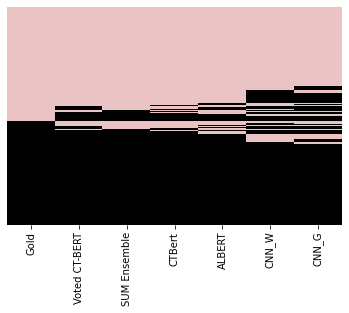

<Figure size 1440x1440 with 0 Axes>

270
30


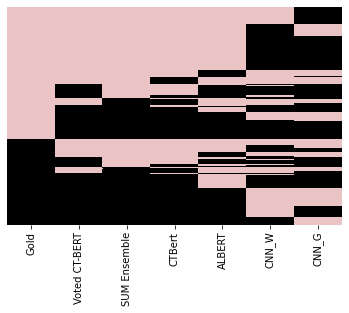

<Figure size 1440x1440 with 0 Axes>

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

workplace=results_df[['gold_labels','ensemble_avg_labels',"voted_bert_labels","ct_bert_labels",'albert_labels','cnn_w2v_labels','cnn_glove_labels']]
sorted_workplace=workplace.sort_values(by=['gold_labels','voted_bert_labels',"ensemble_avg_labels","ct_bert_labels",'albert_labels','cnn_w2v_labels','cnn_glove_labels'])
sorted_workplace

#print(sorted_workplace.groupby(['ACTUAL_LABEL','CNN-LSTM','ATTENTION','BERT-TURKISH']))
sorted_workplace.rename(columns = {'gold_labels':'Gold','voted_bert_labels':'SUM Ensemble','ensemble_avg_labels':'Voted CT-BERT','ct_bert_labels':'CTBert','albert_labels':'ALBERT','cnn_w2v_labels':'CNN_W','cnn_glove_labels':"CNN_G"}, inplace = True) 

#cmaps=['000000','#EAC4C4']
cmaps=['#EAC4C4','000000']

sns.heatmap(sorted_workplace,cmap=cmaps, cbar=False,  yticklabels=False)
#plt.title('Comparison of Predictions made by 3 models')
plt.figure(figsize=(20, 20))  
plt.show()

errors = sorted_workplace.loc[(sorted_workplace['Gold'] != sorted_workplace['SUM Ensemble']) | 
                         (sorted_workplace['Gold'] != sorted_workplace['Voted CT-BERT']) | 
                         
                         (sorted_workplace['Gold'] != sorted_workplace['CTBert']) | 

                         (sorted_workplace['Gold'] != sorted_workplace['ALBERT']) | 
                         (sorted_workplace['Gold'] != sorted_workplace['CNN_W']) | 

                         (sorted_workplace['Gold'] != sorted_workplace['CNN_G'])]


print(len(errors))

common_errors=sorted_workplace.loc[(sorted_workplace['Gold'] != sorted_workplace['SUM Ensemble']) & 
                         (sorted_workplace['Gold'] != sorted_workplace['Voted CT-BERT']) &
                                  
                         (sorted_workplace['Gold'] != sorted_workplace['CTBert']) &
                         (sorted_workplace['Gold'] != sorted_workplace['ALBERT']) &
                         (sorted_workplace['Gold'] != sorted_workplace['CNN_W']) &

                         (sorted_workplace['Gold'] != sorted_workplace['CNN_G']) ]



print(len(common_errors))
#cmaps=['000000','#EAC4C4']
cmaps=['#EAC4C4','000000']

sns.heatmap(errors,cmap=cmaps, cbar=False,  yticklabels=False)
#plt.title('Comparison of Predictions made by 3 models')
plt.figure(figsize=(20, 20))  
plt.show()